<a href="https://colab.research.google.com/github/matrix-mayank/talkmoves-chinesedata/blob/main/TalkMoves_ChineseData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing all the required libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, jaccard_score, f1_score
import torch
from torch import nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import networkx as nx

In [2]:
# Importing our cleaned dataset

df_teacher = pd.read_csv("teachermoves_labeled.csv")
df_teacher.head() # See a couple of rows

,speaker,content,ask_for_expression,say_more,revoice,press_for_reasoning,repeat_add_on,agree_disagree,explain_others,request_choral_response,evaluation,other_moves,speaker_translated,content_translated
0,老師,好啦，咁我哋呢，上堂啦，咁我哋點名嗰度呢我哋唔嘥時間，我哋頭先已經做咗啦。想問下同學啦，記唔...,1,0,0,0,0,0,0,0,0,1,teacher,"Okay, so what about us, let's go to class, so ..."
1,老師,四個直角,0,0,1,0,0,0,0,0,0,0,teacher,four right angles
2,老師,四邊長度相等,0,0,1,0,0,0,0,0,0,0,teacher,Four sides are equal in length
3,老師,兩組對邊長度相等，仲有冇啊？,1,1,1,0,0,0,0,0,0,0,teacher,The two sets of opposite sides are equal in le...
4,老師,兩組對角,0,0,1,0,0,0,0,0,0,0,teacher,Two sets of opposite corners


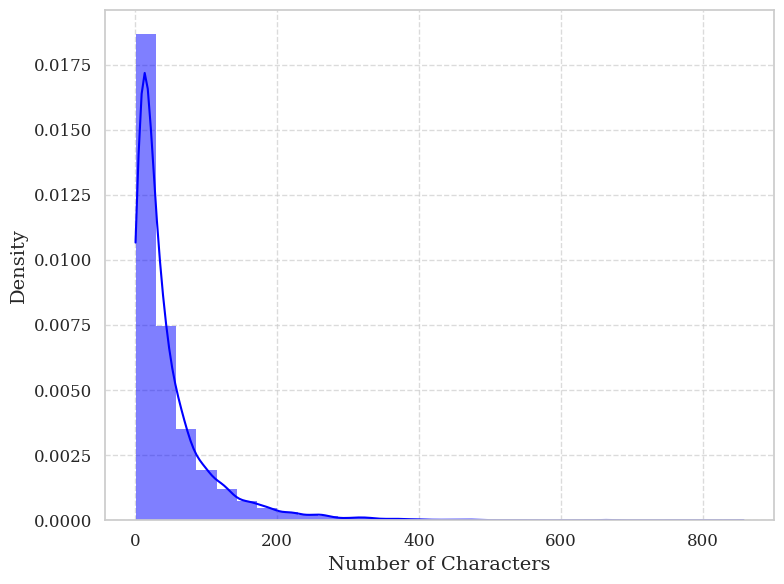

In [22]:
# Plotting length distribution of utterances

df_teacher['content_length'] = df_teacher['content'].apply(len)
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
plt.rcParams["font.family"] = "serif"

# Create the plot with seaborn
sns.histplot(df_teacher['content_length'], kde=True, bins=30, color="blue", stat="density", linewidth=0)

# Add labels (Garamond is now the default font)
plt.xlabel('Number of Characters', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
# Check some statistics
print("Mean = ", np.mean(df_teacher['content_length']))
print("Stdev = ", np.std(df_teacher['content_length']))
print("Minimum = ", np.min(df_teacher['content_length']))
print("Maximum = ", np.max(df_teacher['content_length']))

Mean =  47.69256987048398
Stdev =  59.67808866357977
Minimum =  1
Maximum =  857


In [4]:
# Settings for optimal memory usage and training efficiency of BERT

gc.collect()                # Free unsed CPU memory
torch.cuda.empty_cache()    # Free unused GPU memory

enable_gradient_checkpointing = True    # Reduce memory usage by recomputing activations during backpropagation
max_length = 256                        # Limit sequence length for BERT input
batch_size = 8                          # Number of samples per batch
accumulation_steps = 4                  # Perform gradient accumulation to simulate a larger batch size

In [5]:
# Settings for prediction/inference
# Prioritizing a greater recall over precision by setting threshold to 0.4

prediction_threshold = 0.4

In [6]:
# Settings for oversampling

use_oversampling = True     # Boolean to indicate whether to apply oversampling
target_ratio = 0.2          # Target ratio for minority classes
min_threshold = 0.1         # Classes below this threshold will be oversampled

In [10]:
# List of talk-move labels
label_columns = [
    'ask_for_expression', 'say_more', 'revoice', 'press_for_reasoning',
    'repeat_add_on', 'agree_disagree', 'explain_others',
    'request_choral_response', 'evaluation', 'other_moves'
]

# Dictionary of talk-move meanings
cultural_context = {
    'ask_for_expression': "Direct questioning common in Confucian teaching tradition",
    'say_more': "Encourages elaboration while maintaining teacher authority",
    'revoice': "Reinforces correct response patterns aligned with collective learning",
    'press_for_reasoning': "Balances inquiry with knowledge transmission",
    'repeat_add_on': "Builds on prior student contributions for collective knowledge building",
    'agree_disagree': "Structured disagreement within respectful classroom hierarchy",
    'explain_others': "Collective meaning-making across student contributions",
    'request_choral_response': "Distinctly East Asian practice emphasizing group participation and harmony",
    'evaluation': "Direct feedback reflecting teacher authority in knowledge transmission",
    'other_moves': "Miscellaneous talk-moves"
}

In [11]:
# Defining the neural network model used in this study

# Custom attention layer to capture label-specific patterns
class LabelAttentionLayer(nn.Module):
    def __init__(self, hidden_size, num_labels):
        super(LabelAttentionLayer, self).__init__()
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=4)
        self.label_embeddings = nn.Parameter(torch.randn(num_labels, hidden_size))
        self.norm = nn.LayerNorm(hidden_size)

    def forward(self, bert_output):
        batch_size = bert_output.size(0)
        label_queries = self.label_embeddings.unsqueeze(0).repeat(batch_size, 1, 1)
        # Self-attention with label queries
        attended_output, _ = self.attention(
            label_queries.transpose(0, 1),
            bert_output.unsqueeze(1).transpose(0, 1),
            bert_output.unsqueeze(1).transpose(0, 1)
        )
        attended_output = attended_output.transpose(0, 1)
        return self.norm(attended_output)


# Enhanced BERT model
class EnhancedTeacherMovesBERT(nn.Module):
    def __init__(self, num_labels):
        super(EnhancedTeacherMovesBERT, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-chinese')
        self.dropout = nn.Dropout(0.2)  # Increased dropout

        # Add label-specific attention layer
        self.label_attention = LabelAttentionLayer(
            self.bert.config.hidden_size,
            num_labels
        )

        # Separate classifiers for each label
        self.classifiers = nn.ModuleList([
            nn.Linear(self.bert.config.hidden_size, 1)
            for _ in range(num_labels)
        ])

        self.use_sigmoid = False

        # Enable gradient checkpointing
        if enable_gradient_checkpointing:
            self.bert.gradient_checkpointing_enable()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)

        # Apply attention
        attended_features = self.label_attention(pooled_output)

        # Apply label-specific classifiers
        logits = []
        for i, classifier in enumerate(self.classifiers):
            label_logit = classifier(attended_features[:, i, :])
            logits.append(label_logit)

        # Combine logits
        logits = torch.cat(logits, dim=1)

        if self.use_sigmoid:
            return torch.sigmoid(logits)
        else:
            return logits

In [12]:
# Perform multi-label oversampling

def multilabel_oversample(X, y, label_columns, threshold=0.1, target_ratio=0.2, max_ratio_multiplier=5):

    print("Applying multilabel oversampling...")

    n_samples, n_labels = y.shape

    # Initialize oversampled variables with original data
    X_oversampled = X.copy()
    y_oversampled = y.copy()

    # Track original class distributions
    original_distributions = {}
    for i, label in enumerate(label_columns):
        positive_count = np.sum(y[:, i])
        positive_ratio = positive_count / n_samples
        original_distributions[label] = {
            'count': positive_count,
            'ratio': positive_ratio
        }
        print(f"{label}: {positive_count} positive samples ({positive_ratio:.4f} ratio)")

    # Identify imbalanced labels that need oversampling
    imbalanced_labels = []
    for i, label in enumerate(label_columns):
        if original_distributions[label]['ratio'] < threshold:
            imbalanced_labels.append((i, label))

    if not imbalanced_labels:
        print("No labels require oversampling.")
        return X_oversampled, y_oversampled

    print(f"\nOversampling {len(imbalanced_labels)} imbalanced labels:")

    # Apply oversampling for each imbalanced label
    for idx, label in imbalanced_labels:
        positive_count = original_distributions[label]['count']
        positive_ratio = original_distributions[label]['ratio']

        # Skip if we have too few positive samples to work with
        if positive_count < 3:
            print(f"  - {label}: Too few positive samples ({positive_count}), skipping")
            continue

        # Find positive samples for this label
        positive_indices = np.where(y[:, idx] == 1)[0]

        # Calculate how many samples to add
        current_count = len(y_oversampled)
        current_positives = np.sum(y_oversampled[:, idx])
        current_ratio = current_positives / current_count

        # Target number of positive samples
        target_positive_count = min(
            # Don't exceed target ratio
            int(target_ratio * current_count / (1 - target_ratio)),
            # Don't oversample too aggressively
            int(positive_count * max_ratio_multiplier)
        )

        # How many samples to add
        samples_to_add = max(0, target_positive_count - current_positives)

        if samples_to_add > 0:
            print(f"  - {label}: Adding {samples_to_add} samples (ratio: {positive_ratio:.4f} → ", end="")

            # Randomly sample with replacement from positive examples
            sampled_indices = np.random.choice(positive_indices, size=samples_to_add, replace=True)

            # Add the sampled examples
            X_oversampled = np.concatenate([X_oversampled, X[sampled_indices]])
            y_oversampled = np.concatenate([y_oversampled, y[sampled_indices]])

            # Calculate new ratio
            new_positives = np.sum(y_oversampled[:, idx])
            new_count = len(y_oversampled)
            new_ratio = new_positives / new_count

            print(f"{new_ratio:.4f})")

    print(f"\nDataset size increased from {n_samples} to {len(X_oversampled)} samples")
    return X_oversampled, y_oversampled

In [13]:
# Custom Dataset class for loading, preprocessing, and formatting data

class TeacherMovesDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True, # Truncate the text if it exceeds max_length
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(self.labels[idx])
        }

In [14]:
# Neural network training function

def train(model, dataloader, optimizer, criterion, device, accumulation_steps):
    model.train()
    # Set parameters to 0 at the beginning
    total_loss = 0
    steps = 0
    optimizer.zero_grad()

    for i, batch in enumerate(tqdm(dataloader)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask)

        # Calculate loss and normalize by accumulation steps
        loss = criterion(outputs, labels) / accumulation_steps

        # Backward pass
        loss.backward()

        # Update weights after accumulation_steps
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Track loss
        total_loss += loss.item() * accumulation_steps
        steps += 1

        # Clear memory
        del input_ids, attention_mask, labels, outputs, loss
        if i % 50 == 0:  # Periodically clear cache
            torch.cuda.empty_cache()

    if steps % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    return total_loss / steps if steps > 0 else 0

In [17]:
def evaluate(model, dataloader, criterion, device, threshold=0.4):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)

            # Apply sigmoid to get probabilities if not already applied in the model
            if not model.use_sigmoid:
                # Use custom threshold for predictions
                predictions = (torch.sigmoid(outputs) > threshold).float()
            else:
                predictions = (outputs > threshold).float()

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Clear memory
            del input_ids, attention_mask, labels, outputs, predictions

    # Convert to numpy arrays
    all_predictions_np = np.array(all_predictions)
    all_labels_np = np.array(all_labels)

    # Calculate co-occurrence matrices
    true_co_occurrence = np.zeros((len(label_columns), len(label_columns)))
    pred_co_occurrence = np.zeros((len(label_columns), len(label_columns)))

    for i in range(len(all_labels_np)):
        for j in range(len(label_columns)):
            for k in range(len(label_columns)):
                if all_labels_np[i, j] == 1 and all_labels_np[i, k] == 1:
                    true_co_occurrence[j, k] += 1
                if all_predictions_np[i, j] == 1 and all_predictions_np[i, k] == 1:
                    pred_co_occurrence[j, k] += 1

    # Normalize co-occurrence matrices
    # Add a small epsilon to prevent division by zero
    epsilon = 1e-10
    true_co_norm = true_co_occurrence / (np.max(true_co_occurrence) + epsilon)
    pred_co_norm = pred_co_occurrence / (np.max(pred_co_occurrence) + epsilon)

    # Calculate Jaccard similarity scores
    jaccard_scores = {}

    # Overall Jaccard similarity (sample-wise)
    sample_jaccard_scores = []
    for i in range(len(all_labels_np)):
        # Handle edge case where both arrays are all zeros
        if np.sum(all_labels_np[i]) == 0 and np.sum(all_predictions_np[i]) == 0:
            sample_jaccard_scores.append(1.0)  # Perfect match of empty sets
        else:
            try:
                score = jaccard_score(all_labels_np[i], all_predictions_np[i])
                sample_jaccard_scores.append(score)
            except Exception:
                # If there's any error in calculation, assume 0 similarity
                sample_jaccard_scores.append(0.0)

    jaccard_scores['overall_sample'] = np.mean(sample_jaccard_scores)

    # Per-label Jaccard similarity
    for i, label in enumerate(label_columns):
        try:
            # Handle case where a label might not have any positive instances
            if np.sum(all_labels_np[:, i]) == 0 and np.sum(all_predictions_np[:, i]) == 0:
                jaccard_scores[label] = 1.0  # Perfect match of empty sets
            else:
                jaccard_scores[label] = jaccard_score(all_labels_np[:, i], all_predictions_np[:, i])
        except Exception:
            # If there's any error in calculation, assume 0 similarity
            jaccard_scores[label] = 0.0

    # Overall Jaccard (label-wise)
    jaccard_scores['overall_label'] = np.mean([jaccard_scores[label] for label in label_columns])

    # Calculate traditional classification metrics
    try:
        classification_report_dict = classification_report(
            all_labels_np.flatten(),
            all_predictions_np.flatten(),
            output_dict=True,
            zero_division=0  # Handle division by zero
        )
    except Exception:
        # Provide a fallback in case of errors
        classification_report_dict = {
            'accuracy': 0.0,
            'macro avg': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0},
            'weighted avg': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}
        }

    # Calculate metrics per label
    label_metrics = {}
    for i, label in enumerate(label_columns):
        try:
            label_report = classification_report(
                all_labels_np[:, i],
                all_predictions_np[:, i],
                output_dict=True,
                zero_division=0  # Handle division by zero
            )

            # Check if the '1' key exists (positive class was present)
            if '1' in label_report:
                label_metrics[label] = {
                    'precision': label_report['1']['precision'],
                    'recall': label_report['1']['recall'],
                    'f1-score': label_report['1']['f1-score'],
                    'support': label_report['1']['support']
                }
            else:
                # Handle the case where class '1' is not in the report
                label_metrics[label] = {
                    'precision': 0.0,
                    'recall': 0.0,
                    'f1-score': 0.0,
                    'support': 0
                }
        except Exception:
            # Provide fallback metrics in case of any errors
            label_metrics[label] = {
                'precision': 0.0,
                'recall': 0.0,
                'f1-score': 0.0,
                'support': 0
            }

    return {
        'loss': total_loss / len(dataloader),
        'predictions': all_predictions_np,
        'true_labels': all_labels_np,
        'jaccard_scores': jaccard_scores,
        'classification_metrics': classification_report_dict,
        'label_metrics': label_metrics,
        'true_co_occurrence': true_co_norm,
        'pred_co_occurrence': pred_co_norm
    }

# Function to visualize co-occurrence matrices
def plot_co_occurrence_matrices(true_co, pred_co, label_columns):
    """
    Create visualizations of co-occurrence matrices
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # Short labels for better visualization
    short_labels = [label[:10] + '...' if len(label) > 10 else label for label in label_columns]

    # Plot heatmaps
    sns.heatmap(true_co, annot=True, fmt=".2f", cmap="Blues", ax=ax1,
                xticklabels=short_labels, yticklabels=short_labels)
    ax1.set_title("True Co-occurrence Patterns")

    sns.heatmap(pred_co, annot=True, fmt=".2f", cmap="Blues", ax=ax2,
                xticklabels=short_labels, yticklabels=short_labels)
    ax2.set_title("Predicted Co-occurrence Patterns")

    plt.tight_layout()
    return fig

Loaded dataset with 7335 samples

Original label distribution:
ask_for_expression: 3903 positive samples (0.5321 ratio)
say_more: 855 positive samples (0.1166 ratio)
revoice: 3542 positive samples (0.4829 ratio)
press_for_reasoning: 1525 positive samples (0.2079 ratio)
repeat_add_on: 1618 positive samples (0.2206 ratio)
agree_disagree: 447 positive samples (0.0609 ratio)
explain_others: 43 positive samples (0.0059 ratio)
request_choral_response: 2670 positive samples (0.3640 ratio)
evaluation: 477 positive samples (0.0650 ratio)
other_moves: 2327 positive samples (0.3172 ratio)
Applying multilabel oversampling...
ask_for_expression: 3111 positive samples (0.5302 ratio)
say_more: 690 positive samples (0.1176 ratio)
revoice: 2808 positive samples (0.4785 ratio)
press_for_reasoning: 1218 positive samples (0.2076 ratio)
repeat_add_on: 1291 positive samples (0.2200 ratio)
agree_disagree: 355 positive samples (0.0605 ratio)
explain_others: 35 positive samples (0.0060 ratio)
request_choral_re

100%|██████████| 1055/1055 [08:12<00:00,  2.14it/s]


Training Loss: 0.7128

Evaluating with threshold: 0.3


100%|██████████| 184/184 [00:23<00:00,  8.00it/s]


Validation Loss: 0.5698

Jaccard Similarity Scores:
Overall (sample-wise): 0.5016
Overall (label-wise): 0.4076

Per-Label Jaccard Scores:
ask_for_expression: 0.6146
say_more: 0.1809
revoice: 0.5605
press_for_reasoning: 0.3317
repeat_add_on: 0.4740
agree_disagree: 0.4104
explain_others: 0.0612
request_choral_response: 0.5169
evaluation: 0.3593
other_moves: 0.5669

Classification Reports:

Classification Report for ask_for_expression:
              precision    recall  f1-score   support

         0.0       0.77      0.51      0.62       675
         1.0       0.68      0.87      0.76       792

    accuracy                           0.71      1467
   macro avg       0.72      0.69      0.69      1467
weighted avg       0.72      0.71      0.69      1467


Classification Report for say_more:
              precision    recall  f1-score   support

         0.0       0.97      0.52      0.67      1302
         1.0       0.19      0.87      0.31       165

    accuracy                       

100%|██████████| 184/184 [00:23<00:00,  7.96it/s]


Validation Loss: 0.5698

Jaccard Similarity Scores:
Overall (sample-wise): 0.5264
Overall (label-wise): 0.4270

Per-Label Jaccard Scores:
ask_for_expression: 0.6114
say_more: 0.1946
revoice: 0.5668
press_for_reasoning: 0.3654
repeat_add_on: 0.5062
agree_disagree: 0.4555
explain_others: 0.0779
request_choral_response: 0.5201
evaluation: 0.3967
other_moves: 0.5755

Classification Reports:

Classification Report for ask_for_expression:
              precision    recall  f1-score   support

         0.0       0.74      0.62      0.67       675
         1.0       0.71      0.81      0.76       792

    accuracy                           0.72      1467
   macro avg       0.72      0.71      0.72      1467
weighted avg       0.72      0.72      0.72      1467


Classification Report for say_more:
              precision    recall  f1-score   support

         0.0       0.96      0.59      0.73      1302
         1.0       0.20      0.82      0.33       165

    accuracy                       

100%|██████████| 184/184 [00:23<00:00,  7.90it/s]


Validation Loss: 0.5698

Jaccard Similarity Scores:
Overall (sample-wise): 0.5392
Overall (label-wise): 0.4435

Per-Label Jaccard Scores:
ask_for_expression: 0.5864
say_more: 0.2059
revoice: 0.5562
press_for_reasoning: 0.3924
repeat_add_on: 0.5444
agree_disagree: 0.5000
explain_others: 0.1154
request_choral_response: 0.5242
evaluation: 0.4372
other_moves: 0.5730

Classification Reports:

Classification Report for ask_for_expression:
              precision    recall  f1-score   support

         0.0       0.69      0.72      0.70       675
         1.0       0.75      0.73      0.74       792

    accuracy                           0.72      1467
   macro avg       0.72      0.72      0.72      1467
weighted avg       0.72      0.72      0.72      1467


Classification Report for say_more:
              precision    recall  f1-score   support

         0.0       0.96      0.66      0.78      1302
         1.0       0.22      0.76      0.34       165

    accuracy                       

100%|██████████| 1055/1055 [08:11<00:00,  2.15it/s]


Training Loss: 0.4480

Evaluating with threshold: 0.3


100%|██████████| 184/184 [00:23<00:00,  7.95it/s]


Validation Loss: 0.5399

Jaccard Similarity Scores:
Overall (sample-wise): 0.5582
Overall (label-wise): 0.4513

Per-Label Jaccard Scores:
ask_for_expression: 0.6527
say_more: 0.2575
revoice: 0.5808
press_for_reasoning: 0.3790
repeat_add_on: 0.4303
agree_disagree: 0.4971
explain_others: 0.1429
request_choral_response: 0.5492
evaluation: 0.4211
other_moves: 0.6021

Classification Reports:

Classification Report for ask_for_expression:
              precision    recall  f1-score   support

         0.0       0.83      0.55      0.66       675
         1.0       0.70      0.90      0.79       792

    accuracy                           0.74      1467
   macro avg       0.76      0.73      0.73      1467
weighted avg       0.76      0.74      0.73      1467


Classification Report for say_more:
              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84      1302
         1.0       0.28      0.78      0.41       165

    accuracy                       

100%|██████████| 184/184 [00:23<00:00,  7.96it/s]


Validation Loss: 0.5399

Jaccard Similarity Scores:
Overall (sample-wise): 0.5851
Overall (label-wise): 0.4743

Per-Label Jaccard Scores:
ask_for_expression: 0.6530
say_more: 0.2910
revoice: 0.6029
press_for_reasoning: 0.4153
repeat_add_on: 0.4658
agree_disagree: 0.5244
explain_others: 0.1429
request_choral_response: 0.5537
evaluation: 0.4634
other_moves: 0.6307

Classification Reports:

Classification Report for ask_for_expression:
              precision    recall  f1-score   support

         0.0       0.78      0.65      0.71       675
         1.0       0.74      0.85      0.79       792

    accuracy                           0.76      1467
   macro avg       0.76      0.75      0.75      1467
weighted avg       0.76      0.76      0.75      1467


Classification Report for say_more:
              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87      1302
         1.0       0.32      0.76      0.45       165

    accuracy                       

100%|██████████| 184/184 [00:23<00:00,  7.89it/s]


Validation Loss: 0.5399

Jaccard Similarity Scores:
Overall (sample-wise): 0.5918
Overall (label-wise): 0.4846

Per-Label Jaccard Scores:
ask_for_expression: 0.6334
say_more: 0.3018
revoice: 0.5853
press_for_reasoning: 0.4227
repeat_add_on: 0.5049
agree_disagree: 0.5658
explain_others: 0.1667
request_choral_response: 0.5485
evaluation: 0.4847
other_moves: 0.6323

Classification Reports:

Classification Report for ask_for_expression:
              precision    recall  f1-score   support

         0.0       0.74      0.73      0.74       675
         1.0       0.77      0.78      0.78       792

    accuracy                           0.76      1467
   macro avg       0.76      0.76      0.76      1467
weighted avg       0.76      0.76      0.76      1467


Classification Report for say_more:
              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89      1302
         1.0       0.34      0.72      0.46       165

    accuracy                       

100%|██████████| 1055/1055 [08:11<00:00,  2.15it/s]


Training Loss: 0.3508

Evaluating with threshold: 0.3


100%|██████████| 184/184 [00:23<00:00,  7.97it/s]


Validation Loss: 0.5260

Jaccard Similarity Scores:
Overall (sample-wise): 0.5832
Overall (label-wise): 0.5073

Per-Label Jaccard Scores:
ask_for_expression: 0.6807
say_more: 0.2182
revoice: 0.6172
press_for_reasoning: 0.4020
repeat_add_on: 0.4733
agree_disagree: 0.7455
explain_others: 0.1579
request_choral_response: 0.5754
evaluation: 0.5974
other_moves: 0.6057

Classification Reports:

Classification Report for ask_for_expression:
              precision    recall  f1-score   support

         0.0       0.82      0.66      0.73       675
         1.0       0.75      0.88      0.81       792

    accuracy                           0.78      1467
   macro avg       0.79      0.77      0.77      1467
weighted avg       0.78      0.78      0.77      1467


Classification Report for say_more:
              precision    recall  f1-score   support

         0.0       0.98      0.61      0.75      1302
         1.0       0.22      0.88      0.36       165

    accuracy                       

100%|██████████| 184/184 [00:23<00:00,  7.98it/s]


Validation Loss: 0.5260

Jaccard Similarity Scores:
Overall (sample-wise): 0.5990
Overall (label-wise): 0.5198

Per-Label Jaccard Scores:
ask_for_expression: 0.6711
say_more: 0.2407
revoice: 0.6144
press_for_reasoning: 0.4249
repeat_add_on: 0.5118
agree_disagree: 0.7248
explain_others: 0.2143
request_choral_response: 0.5698
evaluation: 0.6190
other_moves: 0.6068

Classification Reports:

Classification Report for ask_for_expression:
              precision    recall  f1-score   support

         0.0       0.79      0.71      0.75       675
         1.0       0.77      0.83      0.80       792

    accuracy                           0.78      1467
   macro avg       0.78      0.77      0.78      1467
weighted avg       0.78      0.78      0.78      1467


Classification Report for say_more:
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.80      1302
         1.0       0.25      0.86      0.39       165

    accuracy                       

100%|██████████| 184/184 [00:23<00:00,  7.91it/s]


Validation Loss: 0.5260

Jaccard Similarity Scores:
Overall (sample-wise): 0.6017
Overall (label-wise): 0.5191

Per-Label Jaccard Scores:
ask_for_expression: 0.6574
say_more: 0.2542
revoice: 0.5758
press_for_reasoning: 0.4433
repeat_add_on: 0.5447
agree_disagree: 0.7383
explain_others: 0.1429
request_choral_response: 0.5669
evaluation: 0.6364
other_moves: 0.6309

Classification Reports:

Classification Report for ask_for_expression:
              precision    recall  f1-score   support

         0.0       0.75      0.79      0.77       675
         1.0       0.81      0.78      0.79       792

    accuracy                           0.78      1467
   macro avg       0.78      0.78      0.78      1467
weighted avg       0.78      0.78      0.78      1467


Classification Report for say_more:
              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82      1302
         1.0       0.27      0.83      0.41       165

    accuracy                       

100%|██████████| 1055/1055 [08:11<00:00,  2.15it/s]


Training Loss: 0.2740

Evaluating with threshold: 0.3


100%|██████████| 184/184 [00:23<00:00,  7.95it/s]


Validation Loss: 0.5544

Jaccard Similarity Scores:
Overall (sample-wise): 0.6272
Overall (label-wise): 0.5347

Per-Label Jaccard Scores:
ask_for_expression: 0.6812
say_more: 0.2671
revoice: 0.6415
press_for_reasoning: 0.4686
repeat_add_on: 0.5502
agree_disagree: 0.6864
explain_others: 0.2353
request_choral_response: 0.5690
evaluation: 0.6503
other_moves: 0.5972

Classification Reports:

Classification Report for ask_for_expression:
              precision    recall  f1-score   support

         0.0       0.80      0.71      0.75       675
         1.0       0.77      0.85      0.81       792

    accuracy                           0.79      1467
   macro avg       0.79      0.78      0.78      1467
weighted avg       0.79      0.79      0.78      1467


Classification Report for say_more:
              precision    recall  f1-score   support

         0.0       0.96      0.77      0.85      1302
         1.0       0.29      0.76      0.42       165

    accuracy                       

100%|██████████| 184/184 [00:23<00:00,  7.96it/s]


Validation Loss: 0.5544

Jaccard Similarity Scores:
Overall (sample-wise): 0.6354
Overall (label-wise): 0.5362

Per-Label Jaccard Scores:
ask_for_expression: 0.6757
say_more: 0.2837
revoice: 0.6300
press_for_reasoning: 0.4881
repeat_add_on: 0.5548
agree_disagree: 0.6957
explain_others: 0.1765
request_choral_response: 0.5698
evaluation: 0.6691
other_moves: 0.6187

Classification Reports:

Classification Report for ask_for_expression:
              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77       675
         1.0       0.80      0.82      0.81       792

    accuracy                           0.79      1467
   macro avg       0.79      0.79      0.79      1467
weighted avg       0.79      0.79      0.79      1467


Classification Report for say_more:
              precision    recall  f1-score   support

         0.0       0.96      0.80      0.87      1302
         1.0       0.32      0.74      0.44       165

    accuracy                       

100%|██████████| 184/184 [00:23<00:00,  7.85it/s]


Validation Loss: 0.5544

Jaccard Similarity Scores:
Overall (sample-wise): 0.6378
Overall (label-wise): 0.5348

Per-Label Jaccard Scores:
ask_for_expression: 0.6642
say_more: 0.3123
revoice: 0.6135
press_for_reasoning: 0.5107
repeat_add_on: 0.5590
agree_disagree: 0.7080
explain_others: 0.1250
request_choral_response: 0.5628
evaluation: 0.6642
other_moves: 0.6287

Classification Reports:

Classification Report for ask_for_expression:
              precision    recall  f1-score   support

         0.0       0.75      0.80      0.78       675
         1.0       0.82      0.78      0.80       792

    accuracy                           0.79      1467
   macro avg       0.79      0.79      0.79      1467
weighted avg       0.79      0.79      0.79      1467


Classification Report for say_more:
              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89      1302
         1.0       0.36      0.72      0.48       165

    accuracy                       

100%|██████████| 1055/1055 [08:10<00:00,  2.15it/s]


Training Loss: 0.2136

Evaluating with threshold: 0.3


100%|██████████| 184/184 [00:23<00:00,  7.99it/s]


Validation Loss: 0.5886

Jaccard Similarity Scores:
Overall (sample-wise): 0.6136
Overall (label-wise): 0.5241

Per-Label Jaccard Scores:
ask_for_expression: 0.7021
say_more: 0.2464
revoice: 0.6317
press_for_reasoning: 0.4643
repeat_add_on: 0.4565
agree_disagree: 0.7069
explain_others: 0.1724
request_choral_response: 0.5834
evaluation: 0.6522
other_moves: 0.6254

Classification Reports:

Classification Report for ask_for_expression:
              precision    recall  f1-score   support

         0.0       0.82      0.73      0.77       675
         1.0       0.79      0.87      0.83       792

    accuracy                           0.80      1467
   macro avg       0.80      0.80      0.80      1467
weighted avg       0.80      0.80      0.80      1467


Classification Report for say_more:
              precision    recall  f1-score   support

         0.0       0.97      0.70      0.81      1302
         1.0       0.26      0.83      0.40       165

    accuracy                       

100%|██████████| 184/184 [00:23<00:00,  7.96it/s]


Validation Loss: 0.5886

Jaccard Similarity Scores:
Overall (sample-wise): 0.6222
Overall (label-wise): 0.5318

Per-Label Jaccard Scores:
ask_for_expression: 0.6944
say_more: 0.2548
revoice: 0.6262
press_for_reasoning: 0.4831
repeat_add_on: 0.4864
agree_disagree: 0.7232
explain_others: 0.1739
request_choral_response: 0.5684
evaluation: 0.6767
other_moves: 0.6306

Classification Reports:

Classification Report for ask_for_expression:
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78       675
         1.0       0.81      0.83      0.82       792

    accuracy                           0.80      1467
   macro avg       0.80      0.80      0.80      1467
weighted avg       0.80      0.80      0.80      1467


Classification Report for say_more:
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83      1302
         1.0       0.27      0.80      0.41       165

    accuracy                       

100%|██████████| 184/184 [00:23<00:00,  7.87it/s]


Validation Loss: 0.5886

Jaccard Similarity Scores:
Overall (sample-wise): 0.6198
Overall (label-wise): 0.5347

Per-Label Jaccard Scores:
ask_for_expression: 0.6717
say_more: 0.2643
revoice: 0.6117
press_for_reasoning: 0.5051
repeat_add_on: 0.5058
agree_disagree: 0.7407
explain_others: 0.1905
request_choral_response: 0.5472
evaluation: 0.6718
other_moves: 0.6380

Classification Reports:

Classification Report for ask_for_expression:
              precision    recall  f1-score   support

         0.0       0.76      0.79      0.78       675
         1.0       0.82      0.79      0.80       792

    accuracy                           0.79      1467
   macro avg       0.79      0.79      0.79      1467
weighted avg       0.79      0.79      0.79      1467


Classification Report for say_more:
              precision    recall  f1-score   support

         0.0       0.96      0.75      0.85      1302
         1.0       0.29      0.78      0.42       165

    accuracy                       

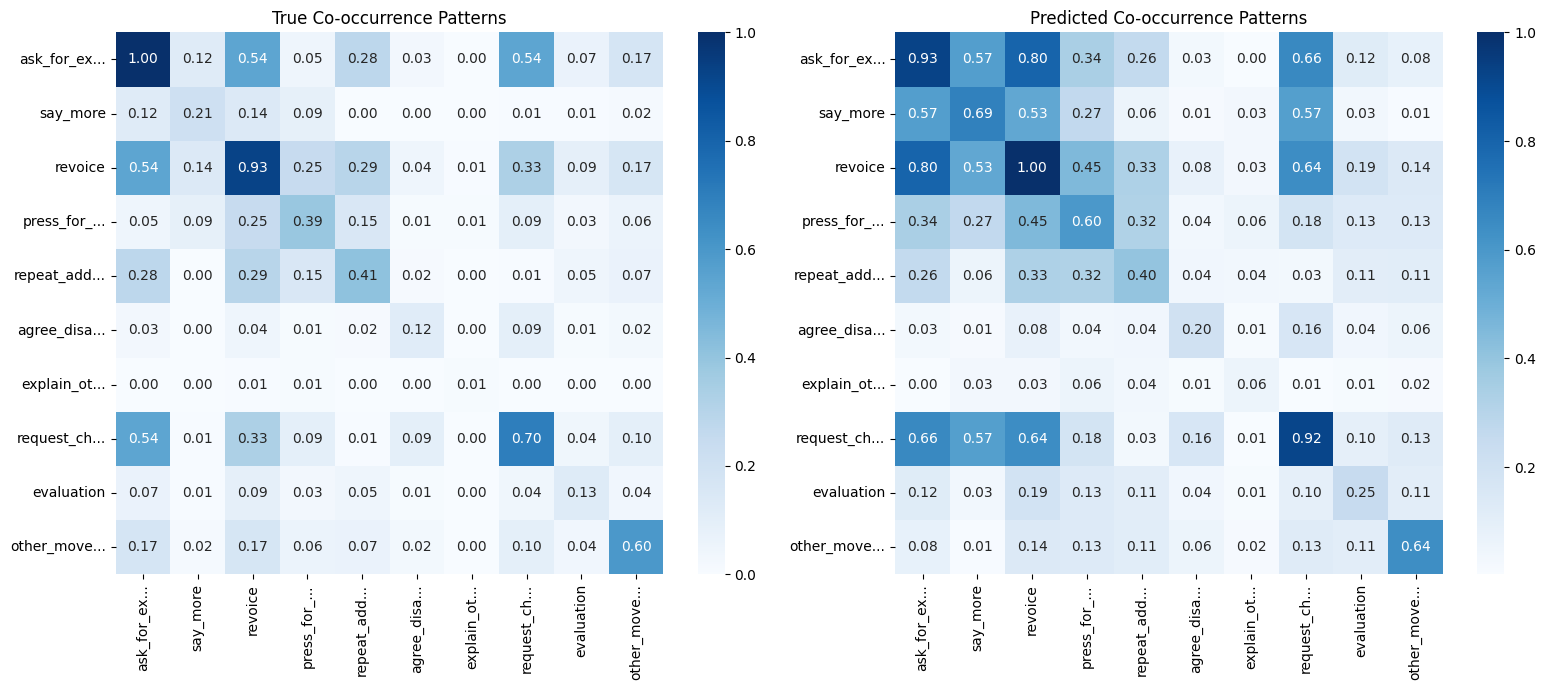

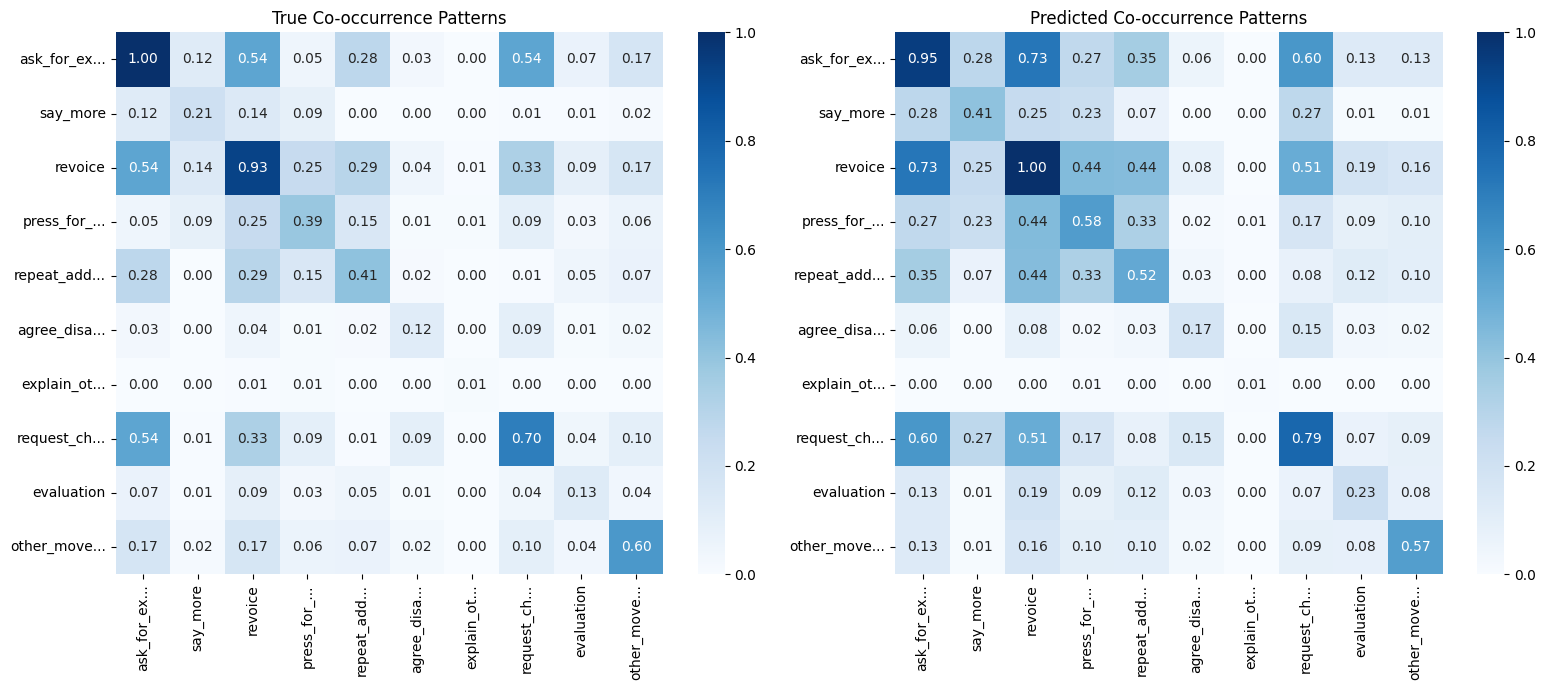

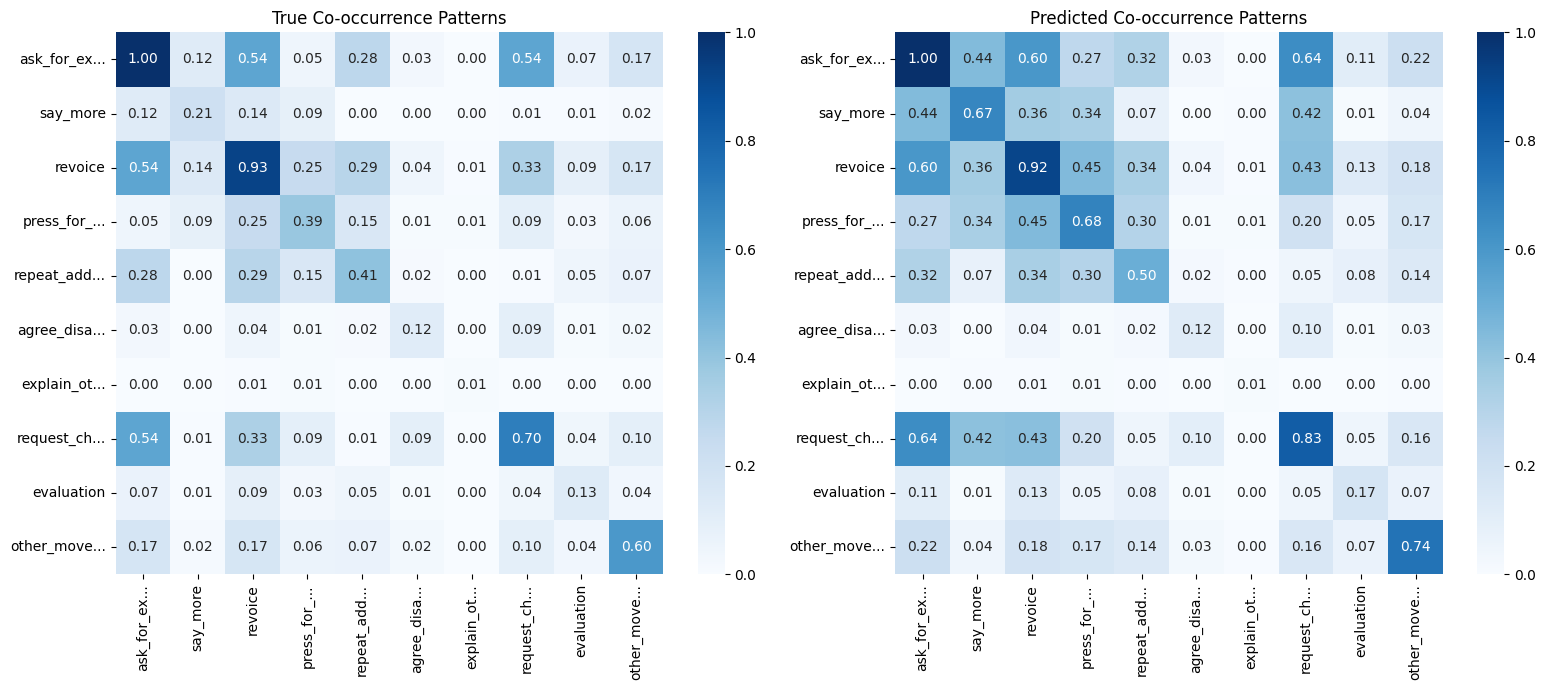

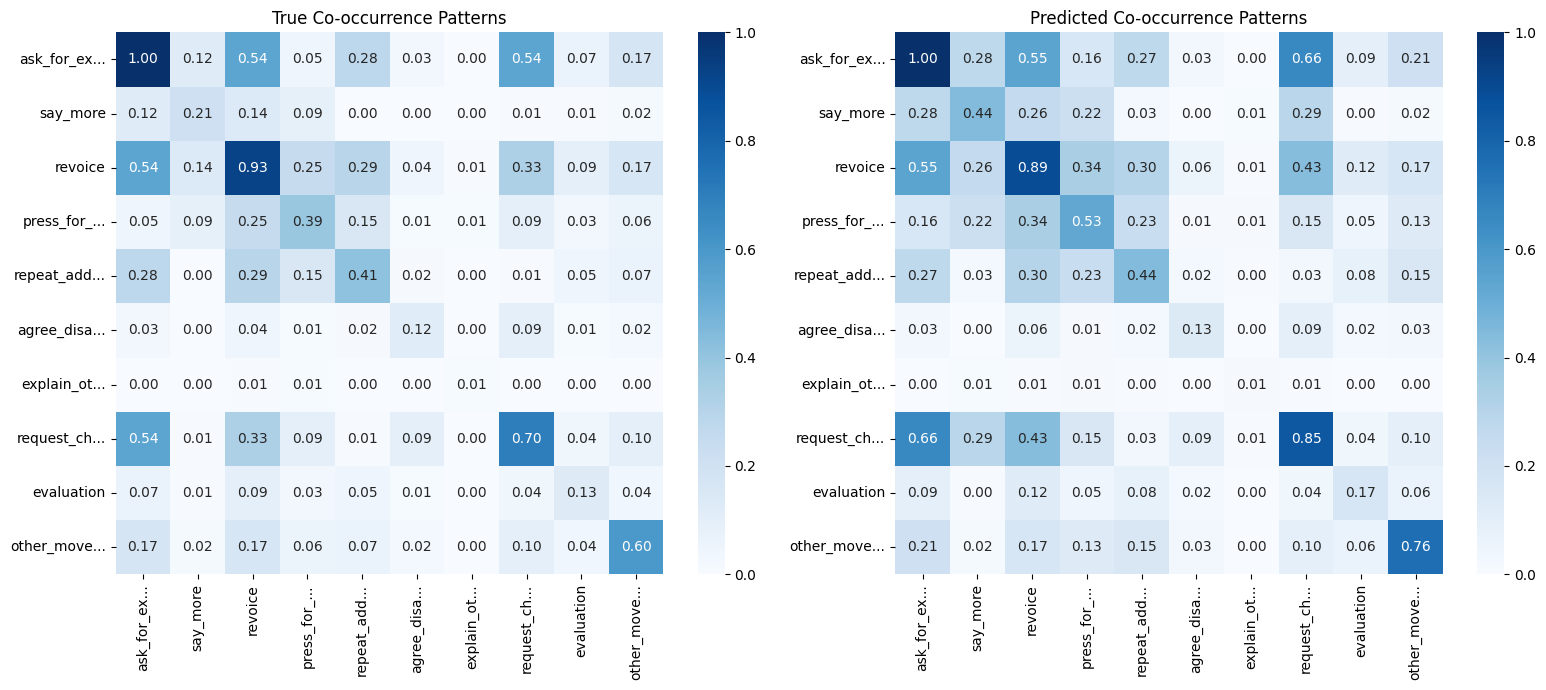

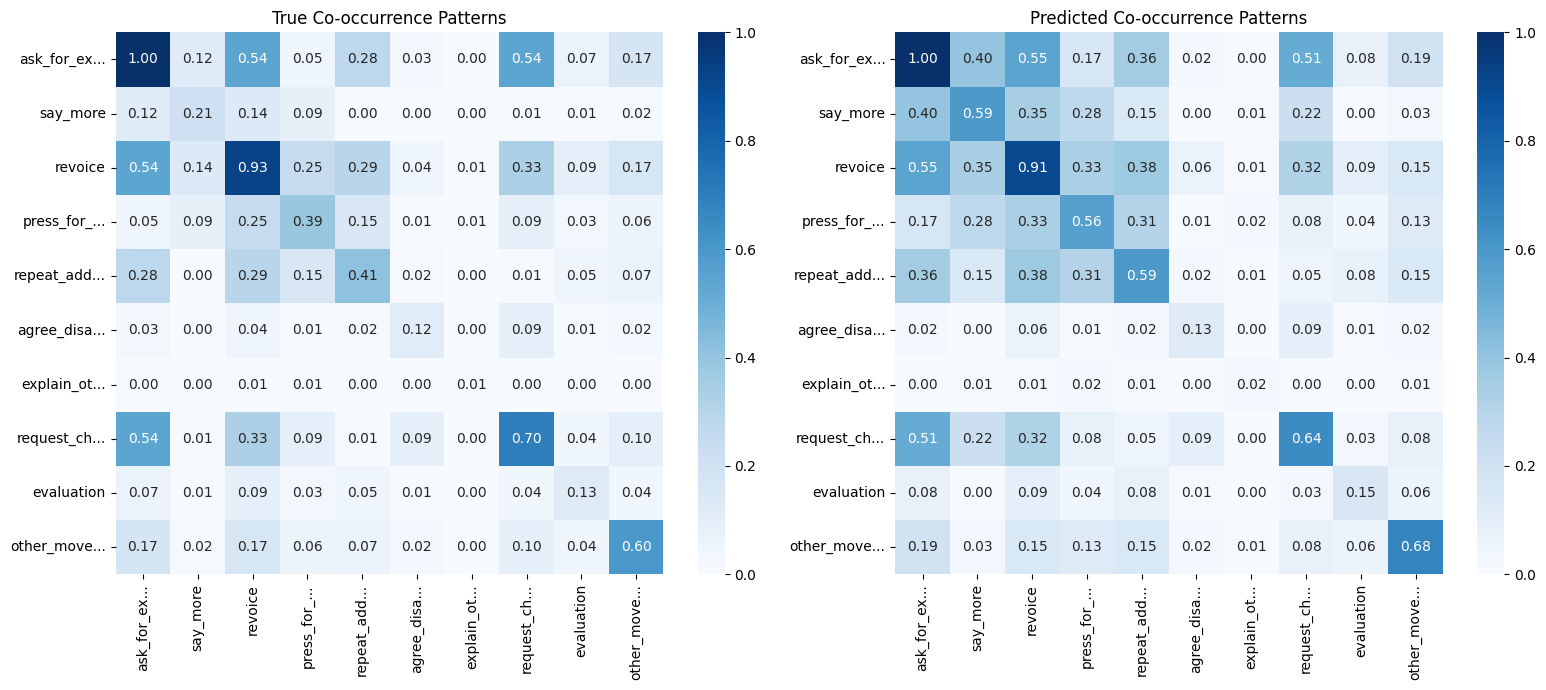

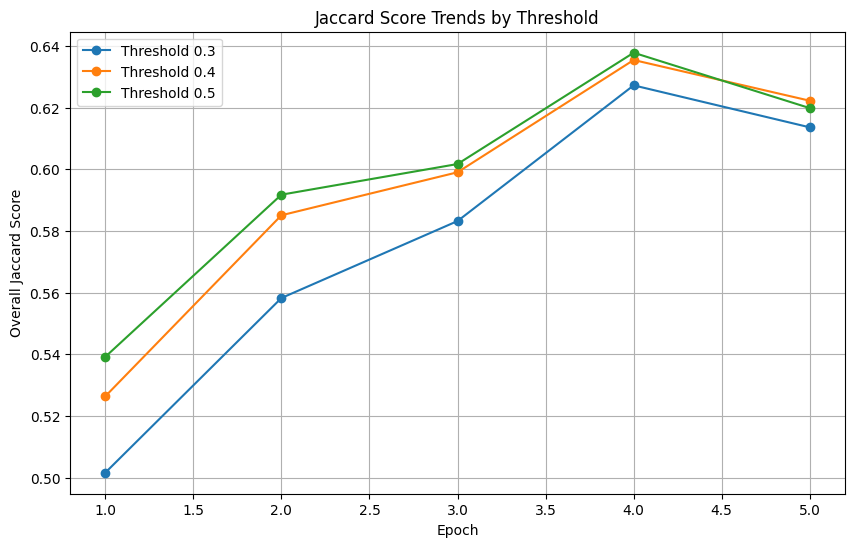

In [18]:
def main():
    # Load dataset
    df_teacher = pd.read_csv("teachermoves_labeled.csv")
    print(f"Loaded dataset with {len(df_teacher)} samples")

    # Print original class distribution
    print("\nOriginal label distribution:")
    for label in label_columns:
        positive_count = df_teacher[label].sum()
        total_count = len(df_teacher)
        print(f"{label}: {positive_count} positive samples ({positive_count/total_count:.4f} ratio)")

    # Slice out input features and output labels
    X = df_teacher['content'].values
    y = df_teacher[label_columns].values

    # Split data - make sure we split before oversampling to avoid data leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply oversampling to the training data
    if use_oversampling:
        X_train_oversampled, y_train_oversampled = multilabel_oversample(
            X_train, y_train, label_columns,
            threshold=min_threshold,
            target_ratio=target_ratio
        )
    else:
        X_train_oversampled, y_train_oversampled = X_train, y_train

    print(f"\nTraining set size: {len(X_train_oversampled)} samples (original: {len(X_train)})")
    print(f"Test set size: {len(X_test)} samples")

    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

    # Create datasets and dataloaders with reduced batch size and sequence length
    train_dataset = TeacherMovesDataset(X_train_oversampled, y_train_oversampled, tokenizer, max_length=max_length)
    test_dataset = TeacherMovesDataset(X_test, y_test, tokenizer, max_length=max_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model, optimizer, and loss function
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Use the enhanced BERT model with cultural attention
    model = EnhancedTeacherMovesBERT(len(label_columns)).to(device)
    print("\nUsing enhanced model with cultural attention mechanism")

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    # Set up weighted BCE loss
    pos_weights = []
    for i, label in enumerate(label_columns):
        # Calculate weights based on the original distribution (not oversampled)
        pos_count = np.sum(y_train[:, i])
        neg_count = len(y_train) - pos_count
        # Weight is higher for minority class (limited to maximum of 10)
        weight = min(10.0, neg_count / max(1, pos_count))
        pos_weights.append(weight)

    # Create weight tensor
    pos_weight = torch.tensor(pos_weights).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    # Don't use sigmoid in the model when using BCEWithLogitsLoss
    model.use_sigmoid = False

    print("\nUsing weighted BCE loss with the following positive weights:")
    for i, label in enumerate(label_columns):
        print(f"{label}: {pos_weights[i]:.2f}")

    # Training loop
    num_epochs = 5
    all_jaccard_scores = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        # Clear memory before each epoch
        gc.collect()
        torch.cuda.empty_cache()

        # Train with gradient accumulation
        train_loss = train(model, train_loader, optimizer, criterion, device, accumulation_steps)
        print(f'Training Loss: {train_loss:.4f}')

        # Clear memory before evaluation
        gc.collect()
        torch.cuda.empty_cache()

        # Try different thresholds for prediction
        thresholds = [0.3, 0.4, 0.5]
        for threshold in thresholds:
            print(f"\nEvaluating with threshold: {threshold}")
            eval_results = evaluate(model, test_loader, criterion, device, threshold=threshold)

            val_loss = eval_results['loss']
            predictions = eval_results['predictions']
            true_labels = eval_results['true_labels']
            jaccard_scores = eval_results['jaccard_scores']

            print(f'Validation Loss: {val_loss:.4f}')

            # Print Jaccard similarity scores
            print("\nJaccard Similarity Scores:")
            print(f"Overall (sample-wise): {jaccard_scores['overall_sample']:.4f}")
            print(f"Overall (label-wise): {jaccard_scores['overall_label']:.4f}")

            print("\nPer-Label Jaccard Scores:")
            for label in label_columns:
                print(f"{label}: {jaccard_scores[label]:.4f}")

            # Store for later analysis
            jaccard_data = {
                'epoch': epoch + 1,
                'threshold': threshold,
                'overall_sample': jaccard_scores['overall_sample'],
                'overall_label': jaccard_scores['overall_label']
            }

            # Add per-label scores
            for label in label_columns:
                jaccard_data[label] = jaccard_scores[label]

            all_jaccard_scores.append(jaccard_data)

            # Print classification report for each label
            print("\nClassification Reports:")
            for i, label in enumerate(label_columns):
                print(f'\nClassification Report for {label}:')
                print(classification_report(true_labels[:, i], predictions[:, i]))

            # Print overall classification metrics
            print('\nOverall Classification Metrics:')
            for metric, value in eval_results['classification_metrics'].items():
                if isinstance(value, dict):
                    continue
                print(f"{metric}: {value:.4f}")

            # Plot co-occurrence matrices for threshold 0.5
            if threshold == 0.5:
                print("\nGenerating co-occurrence matrix visualizations...")
                fig = plot_co_occurrence_matrices(
                    eval_results['true_co_occurrence'],
                    eval_results['pred_co_occurrence'],
                    label_columns
                )
                fig.savefig(f'co_occurrence_matrices_epoch_{epoch+1}.png')
                print(f"Co-occurrence matrices saved as 'co_occurrence_matrices_epoch_{epoch+1}.png'")

    # Analyze trends in Jaccard scores
    if len(all_jaccard_scores) > 0:
        # Convert to DataFrame for easier analysis
        jaccard_df = pd.DataFrame(all_jaccard_scores)

        # Plot overall Jaccard score trends by threshold
        plt.figure(figsize=(10, 6))
        for threshold in jaccard_df['threshold'].unique():
            subset = jaccard_df[jaccard_df['threshold'] == threshold]
            plt.plot(subset['epoch'], subset['overall_sample'],
                    label=f'Threshold {threshold}', marker='o')

        plt.xlabel('Epoch')
        plt.ylabel('Overall Jaccard Score')
        plt.title('Jaccard Score Trends by Threshold')
        plt.legend()
        plt.grid(True)
        plt.savefig('jaccard_trends.png')
        print("Jaccard score trends visualization saved as 'jaccard_trends.png'")

    # Save the model
    torch.save(model.state_dict(), 'teacher_moves_bert_enhanced.pt')
    print("Training completed and model saved!")

if __name__ == "__main__":
    main()